In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('eth_open.csv')
print(df)

      Unnamed: 0 formatted_date         high          low         open  \
0              0     2019-01-01   141.397507   132.650711   141.519516   
1              1     2019-01-02   156.929138   140.650955   155.196045   
2              2     2019-01-03   155.863052   147.198364   148.912888   
3              3     2019-01-04   156.878983   147.907104   154.337418   
4              4     2019-01-05   160.824890   154.337418   155.804230   
...          ...            ...          ...          ...          ...   
1515        1515     2023-02-24  1661.091309  1583.147827  1608.658325   
1516        1516     2023-02-25  1608.865112  1567.631714  1594.761108   
1517        1517     2023-02-26  1645.273438  1590.393066  1640.763672   
1518        1518     2023-02-27  1662.575684  1615.387939  1634.502441   
1519        1519     2023-02-28  1644.435791  1602.428101  1606.040405   

            close      volume     adjclose  
0      140.819412  2258709868   140.819412  
1      155.047684  33

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['open']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['open'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['open'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['open'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['open'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['open'].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv("/BOOSTING/bitcoin_processed_open.csv")
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,119.715439,116.157440,117.110756,117.157852,2421720343,117.157852,3.557999,121.718783,127.202195,135.541803,2.622529,15.117100
21,21,2019-01-22,119.664345,114.676682,118.713814,118.747551,2552507405,118.747551,4.987663,121.276579,124.927847,134.455817,2.855369,15.480982
22,22,2019-01-23,119.422798,116.376648,117.462784,117.452606,2556952198,117.452606,3.046150,120.403613,122.543509,132.658995,2.967977,15.139389
23,23,2019-01-24,118.032104,116.006798,117.594955,117.362885,2520843420,117.362885,2.025307,119.537942,121.813580,131.167665,2.736387,15.000088
24,24,2019-01-25,117.802994,115.830154,116.373528,116.378342,2606881898,116.378342,1.972839,118.789242,121.016826,129.359861,2.790005,14.341288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,1661.091309,1583.147827,1608.658325,1608.373169,8909129423,1608.373169,77.943481,1662.544015,1626.081979,1622.118815,32.378460,64.990272
1516,1516,2023-02-25,1608.865112,1567.631714,1594.761108,1594.914917,5657686235,1594.914917,41.233398,1648.698434,1630.009487,1618.670939,38.065500,64.398841
1517,1517,2023-02-26,1645.273438,1590.393066,1640.763672,1640.817139,5727967432,1640.817139,54.880371,1642.759382,1638.998535,1619.105149,35.067535,64.521318
1518,1518,2023-02-27,1662.575684,1615.387939,1634.502441,1634.326416,7239824677,1634.326416,47.187744,1633.002895,1648.106419,1619.985758,23.005899,64.603103


In [4]:
pre_day =7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['open']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.3)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

450
(1043, 7, 9) (1043, 1) (450, 7, 9) (450, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_open.h5")

Epoch 1/120
40/40 [==============================] - 26s 21ms/step - loss: 0.0147
Epoch 2/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0040
Epoch 3/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0031
Epoch 4/120
40/40 [==============================] - 1s 24ms/step - loss: 0.0036
Epoch 5/120
40/40 [==============================] - 1s 24ms/step - loss: 0.0036
Epoch 6/120
40/40 [==============================] - 1s 23ms/step - loss: 0.0035
Epoch 7/120
40/40 [==============================] - 1s 23ms/step - loss: 0.0030
Epoch 8/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0034
Epoch 9/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0029
Epoch 10/120
40/40 [==============================] - 1s 24ms/step - loss: 0.0024
Epoch 11/120
40/40 [==============================] - 1s 22ms/step - loss: 0.0028
Epoch 12/120
40/40 [==============================] - 1s 23ms/step - loss: 0.0023
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_test)
# predict_price = scala_y.inverse_transform(predict_price)
# y_train_price = scala_y.inverse_transform(y_train)

# error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
# error['error_price'] = error['predict_price'] - error['y_train_price']
# print(error)

15/15 [==============================] - 7s 5ms/step


In [7]:
predict_price = model.predict(x_test)
print(predict_price)

15/15 [==============================] - 0s 5ms/step
[[0.8173261 ]
 [0.8225369 ]
 [0.83705956]
 [0.85381967]
 [0.849406  ]
 [0.8309734 ]
 [0.8241148 ]
 [0.8266226 ]
 [0.80034333]
 [0.7819889 ]
 [0.7870831 ]
 [0.7961182 ]
 [0.7865394 ]
 [0.7890849 ]
 [0.79429644]
 [0.793623  ]
 [0.8038176 ]
 [0.8093396 ]
 [0.8180716 ]
 [0.82529634]
 [0.83440375]
 [0.83806175]
 [0.8407457 ]
 [0.8220729 ]
 [0.79289234]
 [0.77925676]
 [0.7732598 ]
 [0.77494156]
 [0.78183824]
 [0.78149885]
 [0.7868562 ]
 [0.766135  ]
 [0.739195  ]
 [0.70107085]
 [0.6686931 ]
 [0.6592066 ]
 [0.64672786]
 [0.6521134 ]
 [0.66676396]
 [0.66346884]
 [0.6618368 ]
 [0.6672476 ]
 [0.67395574]
 [0.6636544 ]
 [0.65453273]
 [0.6450781 ]
 [0.63579476]
 [0.5750005 ]
 [0.52465034]
 [0.5206465 ]
 [0.5119628 ]
 [0.51417226]
 [0.52201563]
 [0.5087222 ]
 [0.51195246]
 [0.5234207 ]
 [0.52912617]
 [0.535814  ]
 [0.5566654 ]
 [0.5547749 ]
 [0.5508265 ]
 [0.5773109 ]
 [0.60056406]
 [0.61240244]
 [0.62874085]
 [0.6388879 ]
 [0.6536105 ]
 [0.65120

In [8]:



# predict_error = elasticnet.predict(predict_price)
# index=0
predict_price = scala_y.inverse_transform(predict_price)
# for error in predict_error:
#     predict_price[index]+=error
#     index+=1
# print(predict_price)



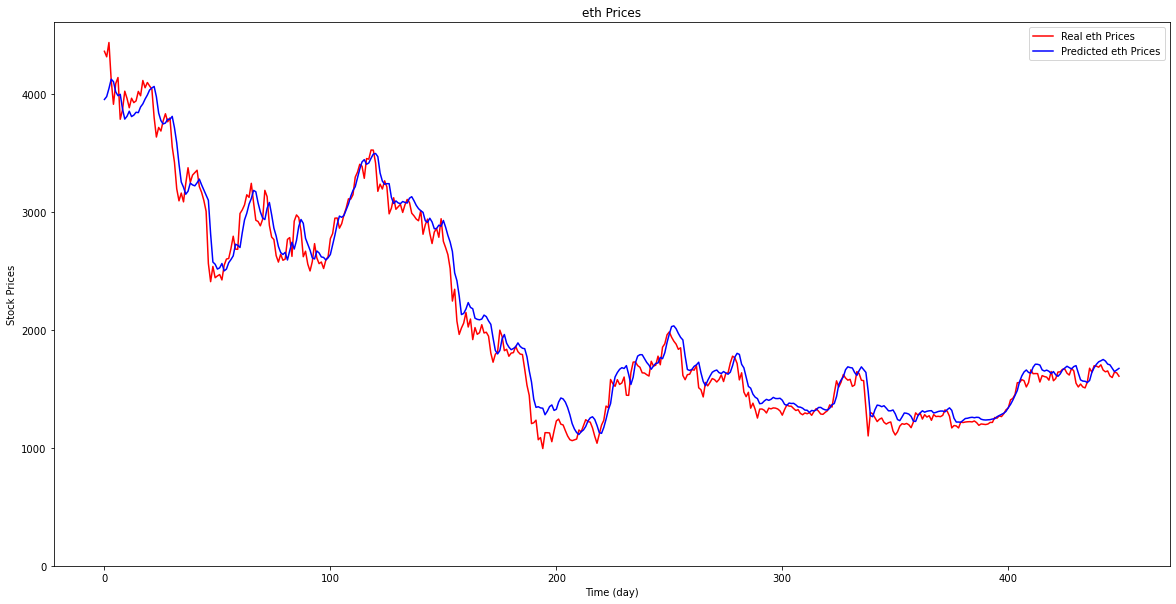

In [9]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real eth Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted eth Prices")
plt.title(f"eth Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [10]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 96.04
MAPE: 5.24%
MSE: 16429.49
RMSE: 128.18
R2: 0.98


In [11]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [12]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))